# Denoising Autoencoders 

Daniel T. Soukup

### Contents
* [Generate training data](#Generate_training_data)
* [Modeling](#Modeling)
* [Model evaluation](#Model_evaluation)
* [Denoising vector field](#Denoising_vector_field)


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import io 

%load_ext tensorboard

<a id="Generate_training_data"></a>
<h2 style="background-color:#9b96d9;"> Generate training data </h2>

We start by a practice run with some toy data, a quadratic curve with Gaussian noise. The model will be trained to remove this noise and recover the true population parabola.

In [2]:
num_samples = 10000
noise_std = 0.05 

def get_data(num_samples):
    """
    Draw circle with radius 0.5
    """
    
    scale = np.pi*np.linspace(-1, 1, num_samples)
    x1 = np.cos(scale)
    x2 = np.sin(scale)
    
    return np.stack([x1, x2], axis=1)*0.5

X = get_data(num_samples)
X_noisy = X + np.random.randn(*X.shape)*noise_std

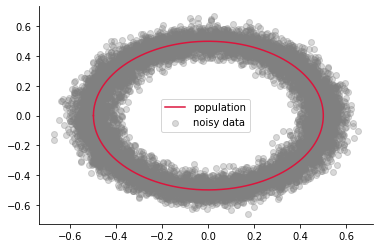

In [3]:
plt.figure()
plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c='gray', alpha=0.3, label="noisy data")
plt.plot(X[:, 0], X[:, 1], c="crimson", label="population")
plt.legend()
sns.despine()
plt.show()

<a id="Modeling"></a>
<h2 style="background-color:#9b96d9;"> Modeling </h2>

Our denoising autoencoder class DAE combines an encoder and decoder and a custom training step. The latter takes the target data, adds noise, feeds this through the encoder/decoder to reconstruct the target and calculates the reconstruction loss (MSE).

Our DAE implements another version as well which instead of noising the target, applies a strong dropout layer right to the input. This didn't perform so well, likely due to the low dimensionality of the input.

In [4]:
class DAE(keras.Model):
    def __init__(self, mode="noise", **kwargs):
        super(DAE, self).__init__(**kwargs)
        
        assert mode in ["noise", "dropout"], f"Mode {mode} not implemented, choose from 'noise' or 'dropout'."
        
        self.mode = mode
        self.encoder = self.get_encoder()
        self.decoder = self.get_decoder()
        
    def get_encoder(self):
        if self.mode == "noise":
            encoder = keras.Sequential(
                [layers.Dense(2, activation="relu"),
                 layers.Dense(8, activation="relu"),
                 layers.Dense(16, activation="relu"),]
            )
        elif self.mode == "dropout":
            encoder = keras.Sequential(
                [layers.Dense(2, activation="relu"),
                 layers.Dropout(0.5),
                 layers.Dense(8, activation="relu"),
                 layers.Dense(16, activation="relu"),]
            ) 
        
        return encoder

    def get_decoder(self):
        decoder = keras.Sequential(
            [layers.Dense(8, activation="relu"),
             layers.Dense(2, activation="tanh")]
        )
        
        return decoder

        
    def call(self, data):
        z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        return reconstruction
    
         
    def test_step(self, data):
        z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
        
        return {
            "loss/reconstruction_loss": reconstruction_loss,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            if self.mode == "noise":
                noise = tf.random.normal(tf.shape(data), mean=0, stddev=noise_std)
                input_data = data + noise
            elif self.mode == "dropout":
                input_data = data

            z = self.encoder(input_data)
            reconstruction = self.decoder(z)
                        
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            ) 
            
        # calculate gradients     
        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        
        # update the weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return  {
            "loss/reconstruction_loss": reconstruction_loss,
            "learning_rate": self.optimizer.lr,
        }

Our autoencoder model will be overcomplete i.e., it has the capacity to learn the identity function if no noise is added to the input. But adding the noise forces the model to learn a useful operation, to remove the noise from the input.

In [5]:
model = DAE(mode="noise")

model.compile(optimizer="adam")

During training, we will log the reconstruction loss on the training and some validation data, and also plot the reconstructions.

In [6]:
### LOGGING ###

# scalar callbacks
logdir = "denoising_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# image callbacks - source: https://www.tensorflow.org/tensorboard/image_summaries
logdir = "denoising_logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + 'reconstruction/')

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_reconstruction(data, preds, show=False):
    base = get_data(1000)
    figure = plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c="gray", alpha=0.3, label="input") # model input
    plt.scatter(preds[:, 0], preds[:, 1], c="blue", alpha=0.5, label="prediction") # prediction
    plt.plot(base[:, 0], base[:, 1], c="crimson", label="population") # population

    plt.legend()
    plt.title("Denoising with an overcomplete autoencoder")
    sns.despine()
    
    if show:
        plt.show()
        
    return figure

def log_reconstruction(epoch, logs):
    reconstruction = model.predict(val_data)

    figure = plot_reconstruction(val_data, reconstruction)
    image = plot_to_image(figure)

    with file_writer.as_default():
        tf.summary.image("Reconstruction", image, step=epoch)

# Define the per-epoch callback.
reconstruction_plot_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_reconstruction)

In [7]:
# clean training data
train_data = X

# noisy validation data
base = get_data(1000)
val_data = base + np.random.randn(*base.shape)*noise_std

# train the model
history = model.fit(train_data,
                    epochs=20,
                    batch_size=32,
                    verbose=0,
                    validation_data=[val_data],   
                    callbacks=[tensorboard_callback, reconstruction_plot_callback],
               )

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Consider rewriting this model with the Functional API.


In [82]:
%tensorboard --logdir denoising_logs/

Reusing TensorBoard on port 6008 (pid 50360), started 17:57:00 ago. (Use '!kill 50360' to kill it.)

<a id="Model_evaluation"></a>
<h2 style="background-color:#9b96d9;"> Model evaluation </h2>

First, we evaluate our model with the same amount of noise added as in training:

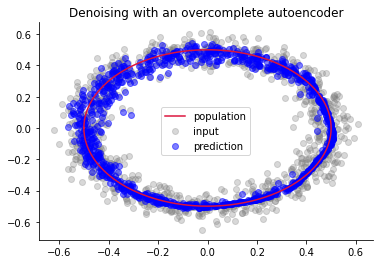

In [8]:
base = get_data(1000)
data = base + np.random.randn(*base.shape)*noise_std
preds = model.predict(data)

figure = plot_reconstruction(data, preds, show=True)

Now, with 5-times the amount of the original training noise:

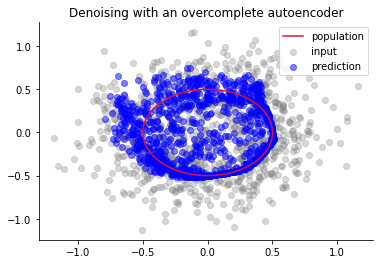

In [9]:
data = base + np.random.randn(*base.shape)*noise_std*5
preds = model.predict(data)

figure = plot_reconstruction(data, preds, show=True)

It's intuitive how the center of the circle is harder to denoise for the model while on the outer areas it still does a good job on large noise.

There also seems to be a fair amount of variation between training runs so I imagine that ensembling a few runs, or averaging the weights across a few model checkpoints could help add some stability.

<a id="Denoising_vector_field"></a>
<h2 style="background-color:#9b96d9;"> Denoising vector field </h2>

We will now see how the model transforms the data space:

In [10]:
# set up a uniform grid
x = np.arange(-1, 1, 0.2)
y = np.arange(-1, 1, 0.2)
xx, yy = np.meshgrid(x, y, sparse=False)
grid_data = np.stack([xx, yy], axis=2)

# calculate the model predictions and deltas
grid_preds = model.predict(grid_data)
pred_delta = grid_preds - grid_data

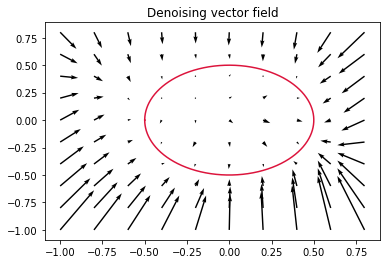

In [11]:
# plot the vector field
fig, ax = plt.subplots()
q = ax.quiver(xx, yy, pred_delta[:, :, 0], pred_delta[:, :, 1], units='xy', scale=2, width=0.01)
base = get_data(1000)
ax.plot(base[:, 0], base[:, 1], c="crimson")
plt.title("Denoising vector field")
plt.show()

Just based on how different the deltas are, using uniform length and color coding might be a better option:

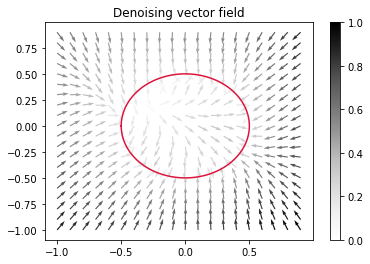

In [12]:
from sklearn.preprocessing import normalize
import matplotlib

# set up a uniform grid
x = np.arange(-1, 1, 0.1)
y = np.arange(-1, 1, 0.1)
xx, yy = np.meshgrid(x, y, sparse=False)
grid_data = np.stack([xx, yy], axis=2)

# calculate the model predictions and deltas
grid_preds = model.predict(grid_data)
pred_delta = grid_preds - grid_data
normalized_delta = normalize(pred_delta.reshape(-1, 2)).reshape(pred_delta.shape)

# color scheme
norm = matplotlib.colors.Normalize()
cm = matplotlib.cm.Greys
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)

fig, ax = plt.subplots()
q = ax.quiver(xx, yy, # arrow base
              normalized_delta[:, :, 0], normalized_delta[:, :, 1], # arrow delta
              np.linalg.norm(pred_delta, axis=-1)**0.5, # colors based on delta norm
              units='xy', 
              scale=10, 
              width=0.01,
             cmap=cm)
base = get_data(1000)
ax.plot(base[:, 0], base[:, 1], c="crimson")
plt.colorbar(sm)
plt.title("Denoising vector field")
plt.savefig("denoising_vector_field.png")
plt.show()

This was fun!